# Neural Network Creation for Future BAH Prediction

We're building an RNN using pytorch that will predict future BAH for O3 using a five year window.

In [25]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
#import data
df = pd.read_csv('clean_df.csv')
df.head()
df.shape

(45310, 37)

<Figure size 1000x500 with 0 Axes>

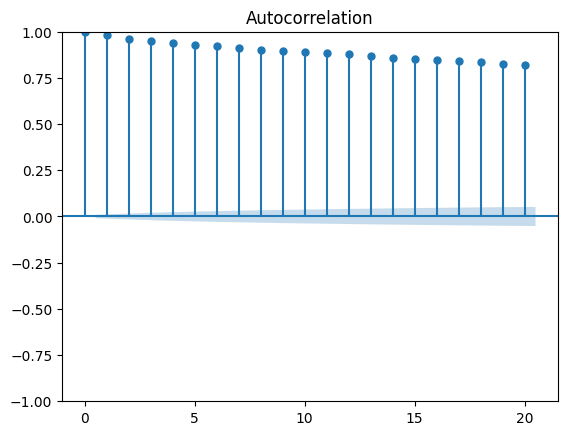

In [102]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plot_acf(df["O3"], lags=20)  # Check up to 20 years of lag
plt.show()


* The first few lags are near 1.0 → This indicates that past BAH values are highly correlated with future values.
*The correlation remains high across all lags (up to 20) → Suggesting that BAH values change very little over time.
* No rapid decay → Normally, a strong time-dependent pattern should show a gradual decrease in correlation, but here, values stay consistently high.

This suggests that BAH rates are highly persistent—meaning that future values are often very close to past values.
This could explain why Linear Regression performed as well as LSTM, since the best prediction might just be "BAH will stay close to its previous value" rather than using a complex time-dependent model.

In [104]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["O3"])
print(f"ADF Statistic: {result[0]}, p-value: {result[1]}")


ADF Statistic: -10.067823887138793, p-value: 1.2822951437083471e-17


statistical properties should be stable over time. p-value < 0.05 → Data is stationary

Before we can begin training our neural network we'll need to prepare the data for training.

# Plan for Data Preprocessing
**Target Variable:** Predict O3 BAH rate.  
**Feature Selection:**  
*   Time-Based Features: Year
*   Geographic Features: MHA, CITY, STATE, Latitude, Longitude
* Economic Indicators: Average CPI, Index (NSA)
* Political Factors: Senate Majority Party, House Majority Party, President Party

**Categorical Encoding:**
Convert MHA, CITY, and STATE to numerical values for PyTorch.
**Split the Data:** Train (70%), Validation (15%), Test (15%)
**Normalization:**
Scale numerical values for better model performance.
**Time Series Formatting:** data from the past 5 years

In [3]:
#encode categorical as integers
label_encoders = {}
categorical_features = ["MHA", "CITY", "STATE"]

for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    label_encoders[feature] = le

In [4]:
#split into training, validation, and testing
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)

We use min-max scaling because it scales values between 0 and 1 which keeps the original distribution and prevents extreme values from dominating. RNNs perform best when input values are small and consistent.

In [79]:
#establish features and target
features = ["Year", "CITY", "Average CPI", "Index (NSA)", "O3"]
target = "O3"

In [80]:
#normalize using min-max scaler training set
scaler_split = MinMaxScaler()
train_df[features + [target]] = scaler_split.fit_transform(train_df[features + [target]])

#apply the same scaler to Validation and Test sets
val_df[features + [target]] = scaler_split.transform(val_df[features + [target]])
test_df[features + [target]] = scaler_split.transform(test_df[features + [target]])

In [81]:
#sort by year and MHA to maintain consistency
df = df.sort_values(by=["MHA", "Year"]).reset_index(drop=True)

In [82]:
#create sequences for 5 year prediction
sequence_length = 5

def create_sequences(data, feature_cols, target_col, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq_data = data.iloc[i:i + seq_length][feature_cols].values
        target_data = data.iloc[i + seq_length][target_col]
        X.append(seq_data)
        y.append(target_data)
    return np.array(X), np.array(y)

In [83]:
def process_for_rnn(data):
    return create_sequences(data, features, target, sequence_length)

X_train, y_train = process_for_rnn(train_df)
X_val, y_val = process_for_rnn(val_df)
X_test, y_test = process_for_rnn(test_df)

In [84]:
X_train.shape, y_train.shape

((31712, 5, 5), (31712,))

In [85]:
X_val.shape, y_val.shape

((6791, 5, 5), (6791,))

In [86]:
X_test.shape, y_test.shape

((6792, 5, 5), (6792,))

# Data Preprocessing Breakdown
Training Data
* 31,714 samples
* each sample uses 5 years of data
* 11 features

Validation Data
* 6,791 samples
* each sample uses 5 years of data
* 11 features

Testing Data
* 6,792 samples
* each sample uses 5 years of data
* 11 features

# Building the RNN
1. Convert data to PyTorch Tensors
2. Define the LSTM Model (RNN with memory for time series forecasting)
3. Train the model
4. Make predictions



In [87]:
#convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [88]:
#create pytorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [89]:
#batch size and data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [90]:
#confirm data set sizes
len(train_dataset), len(val_dataset), len(test_dataset)

(31712, 6791, 6792)

Build the LSTM Model

In [91]:
#define the model
class BAH_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BAH_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        #LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)


        #fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
      c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

      out, _ = self.lstm(x, (h0, c0))  # LSTM forward pass

      out = out[:, -1, :]  # Take only the last time step's output
      out = self.fc(out)  # Fully connected layer
      return out


In [92]:
#model parameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 32  # Number of LSTM neurons
num_layers = 2  # Stacked LSTMs
output_size = 1  # Predicting a single value (O3 BAH rate)

In [93]:
#initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BAH_LSTM(input_size, hidden_size, num_layers, output_size).to(device)

#define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

In [94]:
model

BAH_LSTM(
  (lstm): LSTM(5, 32, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

Train the LSTM

In [95]:
#training parameter epochs
num_epochs = 20

In [96]:
#training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_val_loss = float("inf")  #validation loss
    for epoch in range(num_epochs):
        model.train()  #training mode
        train_loss = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            #forward
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            #backpropagation
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        #average training loss
        train_loss /= len(train_loader)

        #validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        #print epoch results
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        #save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_lstm_model.pth")

In [97]:
#train
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/20], Train Loss: 0.0428, Val Loss: 0.0241
Epoch [2/20], Train Loss: 0.0237, Val Loss: 0.0240
Epoch [3/20], Train Loss: 0.0237, Val Loss: 0.0240
Epoch [4/20], Train Loss: 0.0236, Val Loss: 0.0239
Epoch [5/20], Train Loss: 0.0236, Val Loss: 0.0239
Epoch [6/20], Train Loss: 0.0236, Val Loss: 0.0239
Epoch [7/20], Train Loss: 0.0235, Val Loss: 0.0239
Epoch [8/20], Train Loss: 0.0235, Val Loss: 0.0238
Epoch [9/20], Train Loss: 0.0235, Val Loss: 0.0239
Epoch [10/20], Train Loss: 0.0235, Val Loss: 0.0238
Epoch [11/20], Train Loss: 0.0235, Val Loss: 0.0238
Epoch [12/20], Train Loss: 0.0235, Val Loss: 0.0239
Epoch [13/20], Train Loss: 0.0235, Val Loss: 0.0239
Epoch [14/20], Train Loss: 0.0235, Val Loss: 0.0238
Epoch [15/20], Train Loss: 0.0235, Val Loss: 0.0238
Epoch [16/20], Train Loss: 0.0235, Val Loss: 0.0239
Epoch [17/20], Train Loss: 0.0235, Val Loss: 0.0238
Epoch [18/20], Train Loss: 0.0234, Val Loss: 0.0238
Epoch [19/20], Train Loss: 0.0235, Val Loss: 0.0238
Epoch [20/20], Train 

In [98]:
# Define a simple Linear Regression model for baseline comparison
class SimpleLinear(nn.Module):
    def __init__(self, input_size):
        super(SimpleLinear, self).__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.fc(x[:, -1, :])  # Use last time step

# Initialize the model
linear_model = SimpleLinear(input_size).to(device)

# Define loss function and optimizer for linear regression
linear_criterion = nn.MSELoss()
linear_optimizer = torch.optim.Adam(linear_model.parameters(), lr=0.001)

# Training loop for linear regression
def train_linear_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backpropagation
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Print epoch results
        print(f"Epoch [{epoch+1}/20], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Train the baseline linear model
train_linear_model(linear_model, train_loader, val_loader, linear_criterion, linear_optimizer)


Epoch [1/20], Train Loss: 0.1596, Val Loss: 0.0284
Epoch [2/20], Train Loss: 0.0269, Val Loss: 0.0260
Epoch [3/20], Train Loss: 0.0256, Val Loss: 0.0251
Epoch [4/20], Train Loss: 0.0247, Val Loss: 0.0245
Epoch [5/20], Train Loss: 0.0241, Val Loss: 0.0241
Epoch [6/20], Train Loss: 0.0238, Val Loss: 0.0240
Epoch [7/20], Train Loss: 0.0236, Val Loss: 0.0239
Epoch [8/20], Train Loss: 0.0235, Val Loss: 0.0239
Epoch [9/20], Train Loss: 0.0235, Val Loss: 0.0238
Epoch [10/20], Train Loss: 0.0234, Val Loss: 0.0238
Epoch [11/20], Train Loss: 0.0234, Val Loss: 0.0239
Epoch [12/20], Train Loss: 0.0235, Val Loss: 0.0238
Epoch [13/20], Train Loss: 0.0234, Val Loss: 0.0239
Epoch [14/20], Train Loss: 0.0234, Val Loss: 0.0239
Epoch [15/20], Train Loss: 0.0235, Val Loss: 0.0239
Epoch [16/20], Train Loss: 0.0234, Val Loss: 0.0239
Epoch [17/20], Train Loss: 0.0234, Val Loss: 0.0239
Epoch [18/20], Train Loss: 0.0234, Val Loss: 0.0239
Epoch [19/20], Train Loss: 0.0235, Val Loss: 0.0239
Epoch [20/20], Train 

LSTM isn't effectively capturing time dependencies

The BAH rate may not depend on a long history.
Older data might not add predictive value (sequence length might be too long).
The model might be too complex for the dataset
Four LSTM layers could be too deep, making learning unstable.
The model might memorize noise instead of real patterns.
LSTM's learning rate and weight updates may be inefficient
Learning rate may be too low (not updating weights fast enough).
Weight initialization might be poor.

 The most recent year’s data might be enough to predict BAH, making a simple model sufficient.
The relationships between features and BAH rates are mostly linear.
Time-series dependencies (long-term trends) are weak—most predictive power comes from recent data.

Let's switch to a XGBoost or Random Forest Method

XGBoost can handle both linear & non-linear relationships better than LSTMs.
It’s easier to interpret and requires less tuning.

Testing both NNs (LSTM and Linear Regression) on validation data

In [99]:
def evaluate_model(model, val_loader, criterion):
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():  # No need to track gradients during evaluation
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Get model predictions
            outputs = model(batch_X)

            # Compute loss
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

            # Store predictions and actual values
            all_predictions.extend(outputs.cpu().numpy().flatten())
            all_targets.extend(batch_y.cpu().numpy().flatten())

    # Debugging print statements
    print(f"Total Predictions: {len(all_predictions)}, Total Targets: {len(all_targets)}")

    # Ensure predictions and targets are the same length
    min_length = min(len(all_predictions), len(all_targets))
    all_predictions = all_predictions[:min_length]
    all_targets = all_targets[:min_length]

    # Compute additional metrics
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    r2 = r2_score(all_targets, all_predictions)

    return {
        "Validation Loss (MSE)": val_loss / len(val_loader),
        "Mean Absolute Error (MAE)": mae,
        "Root Mean Squared Error (RMSE)": rmse,
        "R² Score": r2,
    }



In [100]:
# Evaluate LSTM Model
lstm_metrics = evaluate_model(model, test_loader, criterion)
print(f"LSTM Model Performance:\n{lstm_metrics}")

# Evaluate Linear Regression Model
linear_metrics = evaluate_model(linear_model, test_loader, linear_criterion)
print(f"Linear Regression Model Performance:\n{linear_metrics}")

Total Predictions: 6792, Total Targets: 6792
LSTM Model Performance:
{'Validation Loss (MSE)': 0.024199871738032203, 'Mean Absolute Error (MAE)': 0.11812964733744871, 'Root Mean Squared Error (RMSE)': 0.15470358775025028, 'R² Score': -0.0001737199490203789}
Total Predictions: 6792, Total Targets: 6792
Linear Regression Model Performance:
{'Validation Loss (MSE)': 0.024195202373873407, 'Mean Absolute Error (MAE)': 0.11806983632738707, 'Root Mean Squared Error (RMSE)': 0.15469788731908937, 'R² Score': -0.00010001362480327458}


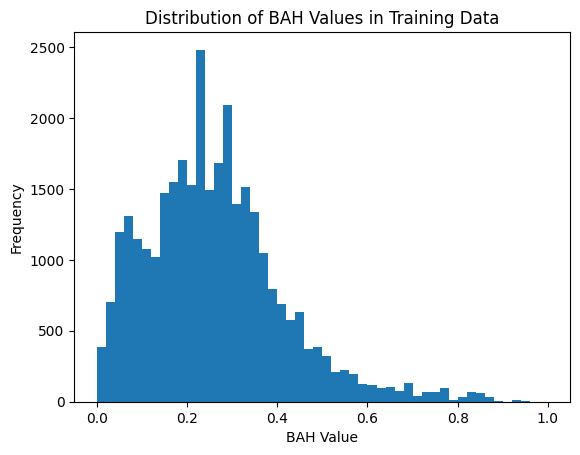

In [101]:
import matplotlib.pyplot as plt
plt.hist(y_train, bins=50)
plt.xlabel("BAH Value")
plt.ylabel("Frequency")
plt.title("Distribution of BAH Values in Training Data")
plt.show()


In [78]:
from xgboost import XGBRegressor

X_train_simple = X_train[:, -1, :]  # Use only last time step
X_val_simple = X_val[:, -1, :]
X_test_simple = X_test[:, -1, :]

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train_simple, y_train)

# Evaluate on validation set
xgb_predictions = xgb_model.predict(X_val_simple)
xgb_r2 = r2_score(y_val, xgb_predictions)
print(f"XGBoost R² Score: {xgb_r2:.4f}")



XGBoost R² Score: -0.0099


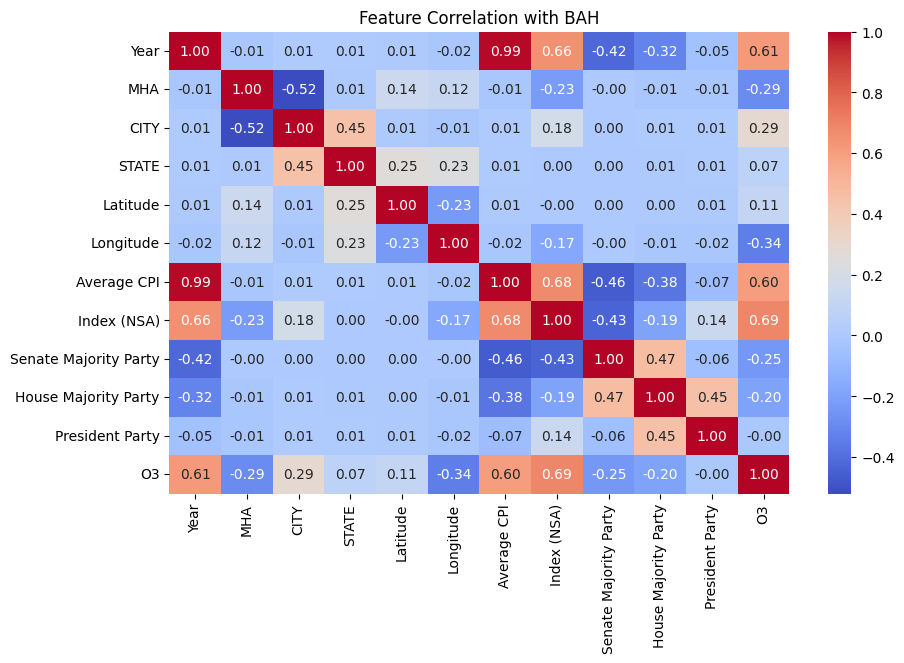

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert DataFrame back to original values (undo scaling)
df_original = df.copy()

features2 = ["Year", "MHA", "CITY", "STATE", "Latitude", "Longitude", "Average CPI", "Index (NSA)",
            "Senate Majority Party", "House Majority Party", "President Party", "O3"]

# Compute correlation matrix
correlation_matrix = df_original[features2].corr()

# Visualize correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation with BAH")
plt.show()
